# **Installing all the required libraries**


In [1]:
!pip install langchain_community nltk==3.5 sacrebleu sacremoses

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 974.0/974.0 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.7/314.7 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.1 MB/s eta 0:00:00
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434678 sha2

# **Libraries and Imports**
* WebBaseLoader from langchain_community.document_loaders is used for fetching and processing web documents. It is particularly used for retrieveing the wikipedia article being searched for.
* RecursiveCharacterTextSplitter splits long texts into smaller, manageable chunks based on character count, ensuring the chunks fit within token limits for processing by language models.
* BLEU score,Translation Edit Rate (TER), and ChrF score are the metrices for the evaluation of the translations.

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast, MarianMTModel, MarianTokenizer
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_metric
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time


# **Loading data from wikipedia**
The WebBaseLoader is initialized with the URL of the Wikipedia page for Koalas in German ("https://de.wikipedia.org/wiki/koala"). This sets up the loader to fetch and process the content from this URL.

In [3]:
#load the required url
loader = WebBaseLoader("https://de.wikipedia.org/wiki/Koala")
#load the data
data = loader.load()

# **Data Preprocessing**
Unwanted characters such as newlines, pipes, slashes, parentheses, square brackets, and backslashes are removed from each chunk.The beginning and end of each chunk are trimmed to remove extraneous content. This preprocessing step ensures that the text chunks are cleaned and ready for further processing or analysis.

**Splitting large texts**

split_documents() method of the text_splitter instance to split the loaded data into smaller chunks. The data variable, which contains the text loaded from the web page, is divided into chunks based on the specified chunk_size (Each chunk will have a maximum of 2000 characters) and chunk_overlap (There will be an overlap of 200 characters between consecutive chunks. This ensures that important information at the boundaries of chunks is not lost.) The resulting chunks are stored in the docs variable.

In [4]:
#split the data into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=100, )
docs= text_splitter.split_documents(data)

In [5]:
# Create a translation table that maps each character to None
remove_chars = "|\\/()[]"
translation_table = str.maketrans('', '', remove_chars)

In [6]:
#remove unwanted characters in each chunk of data
for i in range(0, len(docs)):
  if docs[i] is not None:
    docs[i] = str(docs[i]).replace("\\n", "").translate(translation_table)
    docs[i] = docs[i][22:-104]

# **Inference using different models**
* **mBART:** The model can translate directly between any pair of 50 languages. To translate into a target language, the target language id is forced as the first generated token. To force the target language id as the first generated token, pass the forced_bos_token_id parameter to the generate method.
* **MarianMT:** The model "Helsinki-NLP/opus-mt-de-en" is a neural machine translation model designed specifically for translating text from German (de) to English (en), and it is part of the OPUS-MT project developed by the Helsinki-NLP group.
* **Tsmall100:** It is a compact and fast massively multilingual machine translation model covering more than 10K language pairs, that achieves competitive results while being much smaller and faster. 

In [7]:
# Models and Tokenizers
models = {
    "MarianMT": ("Helsinki-NLP/opus-mt-de-en", MarianMTModel, MarianTokenizer),
    "mBART": ("facebook/mbart-large-50-many-to-many-mmt", MBartForConditionalGeneration, MBart50TokenizerFast),
    "Tsmall100": ("alirezamsh/small100", AutoModelForSeq2SeqLM, AutoTokenizer)
}

In [8]:
df = pd.DataFrame({})
inferenceTime = {}

In [9]:
for model_name, (model_checkpoint, model_class, tokenizer_class) in models.items():
    # Load model and tokenizer
    print(model_name)
    model = model_class.from_pretrained(model_checkpoint)
    tokenizer = tokenizer_class.from_pretrained(model_checkpoint)
    translated = []
    #translate each chunk to english
    start_time = time.time()
    for i in range(0, len(docs)):
        if model_name == "mBART":
            tokenizer.src_lang = "de_DE"
            encoded_de = tokenizer(docs[i], return_tensors="pt")
            generated_tokens = model.generate(
                **encoded_de,
                forced_bos_token_id=tokenizer.lang_code_to_id["en_XX"]
            )
            translated.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))
        elif model_name == "Tsmall100":
            encoded_de = tokenizer(docs[i], return_tensors="pt")
            generated_tokens = model.generate(**encoded_de)
            translated.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))
        else:
            encoded_de = tokenizer(docs[i], return_tensors="pt", max_length=512, truncation=True)
            generated_tokens = model.generate(**encoded_de)
            translated.append(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))
    translated_text = [element[0] for element in translated]
    end_time = time.time()
    inference_time = end_time - start_time
    inferenceTime[model_name] = inference_time
    df[model_name] = translated_text
    df.to_csv("translation.csv", index=False)

MarianMT


config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

mBART


config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

Tsmall100


config.json:   0%|          | 0.00/890 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

# **Calculating BLEU Scores**
**BLEU:** The score evaluates the quality of machine-generated translations by comparing them to reference translations. Weights define the importance of different n-grams in the BLEU score calculation.

**TER:** The Translation Edit Rate score measures the number of edits required to change a machine-translated output into one of the reference translations, with a lower score indicating a higher quality translation.

**ChrF:** The Character F-score metric is another evaluation metric for machine translation quality, which computes precision and recall over character n-grams, not word n-grams.

In [10]:
bleu_metric = load_metric('sacrebleu', trust_remote_code=True)
ter_metric = load_metric('ter', trust_remote_code=True)
chrf_metric = load_metric('chrf', trust_remote_code=True)

/tmp/ipykernel_18/3292757419.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('sacrebleu', trust_remote_code=True)


In [11]:
# Functions to evaluate translations
def evaluate_bleu(predictions, references):
    return bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
def evaluate_chrf(predictions, references):
    return chrf_metric.compute(predictions=[pred.split() for pred in predictions], references=[[ref.split()] for ref in references])
def evaluate_ter(predictions, references):
    return ter_metric.compute(predictions=[pred.split() for pred in predictions], references=[[ref.split()] for ref in references])

In [12]:
results = {}
keys = list(models.keys())

# Calculate all pairwise comparisons
for i in range(len(keys)):
    for j in range(len(keys)):
        if i != j:
            bleu = evaluate_bleu(df[keys[i]], df[keys[j]])
            ter = evaluate_ter(df[keys[i]], df[keys[j]])
            chrf = evaluate_chrf(df[keys[i]], df[keys[j]])
            results[(keys[i], keys[j])] = {
                "BLEU": bleu,
                "TER": ter,
                "ChrF": chrf
            }

In [13]:
for model, time_s in inferenceTime.items():
        print(f"Inferece time of {model}: {time_s}")
for (model1, model2), result in results.items():
    print(f"Model: {model1} to {model2}")
    for metric, score in result.items():
        print(f"  {metric}: {score}")

Inferece time of MarianMT: 361.85710048675537
Inferece time of mBART: 2156.1424157619476
Inferece time of Tsmall100: 1100.4098744392395
Model: MarianMT to mBART
  BLEU: {'score': 33.875164732592836, 'counts': [2586, 1880, 1459, 1153], 'totals': [5038, 5007, 4977, 4947], 'precisions': [51.329892814608975, 37.547433592969846, 29.314848302190075, 23.307054780675156], 'bp': 1.0, 'sys_len': 5038, 'ref_len': 4136}
  TER: {'score': 83.93930718580017, 'num_edits': 2932, 'ref_length': 3493.0}
  ChrF: {'score': 66.5040672551126, 'char_order': 6, 'word_order': 0, 'beta': 2}
Model: MarianMT to Tsmall100
  BLEU: {'score': 28.4891595593901, 'counts': [2501, 1616, 1173, 863], 'totals': [5038, 5007, 4977, 4947], 'precisions': [49.64271536323938, 32.27481525863791, 23.568414707655215, 17.444916110774205], 'bp': 1.0, 'sys_len': 5038, 'ref_len': 4502}
  TER: {'score': 83.58856559469116, 'num_edits': 3275, 'ref_length': 3918.0}
  ChrF: {'score': 61.30267331422221, 'char_order': 6, 'word_order': 0, 'beta':

# **Visualising the results**

In [14]:
# Initialize dictionaries to hold DataFrames for each metric
metrics = ['BLEU', 'TER', 'ChrF']
metric_dfs = {metric: pd.DataFrame(index=keys, columns=keys) for metric in metrics}

# Populate the DataFrames with the 'score' from each metric's dictionary
for (model1, model2), scores in results.items():
    for metric in metrics:
        metric_dfs[metric].at[model1, model2] = scores[metric]['score']

In [15]:
def plot_heatmap(df, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.astype(float), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title(title)
    plt.show()

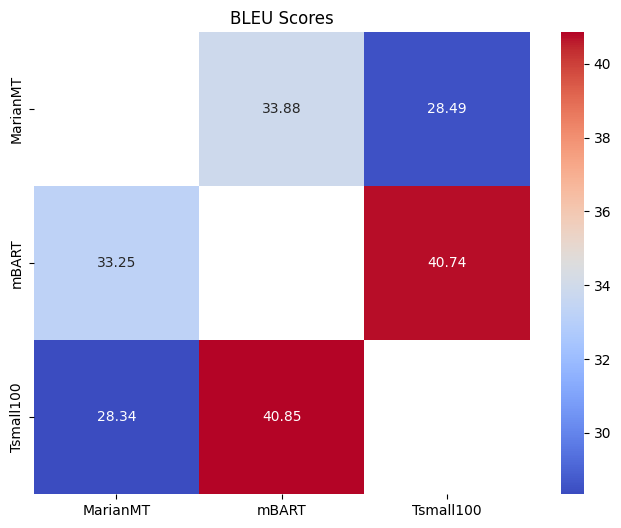

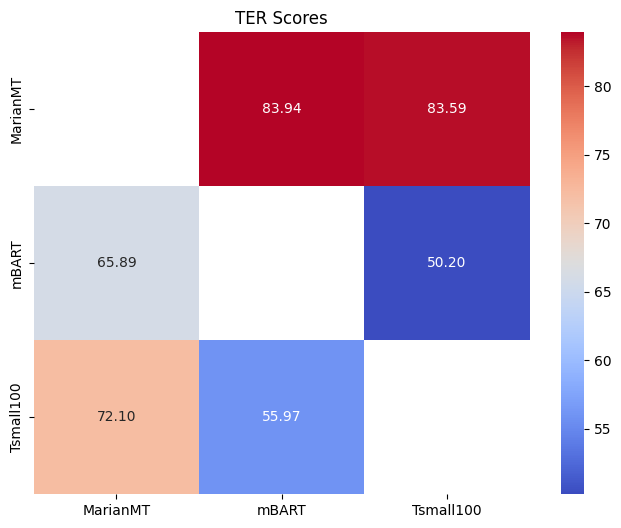

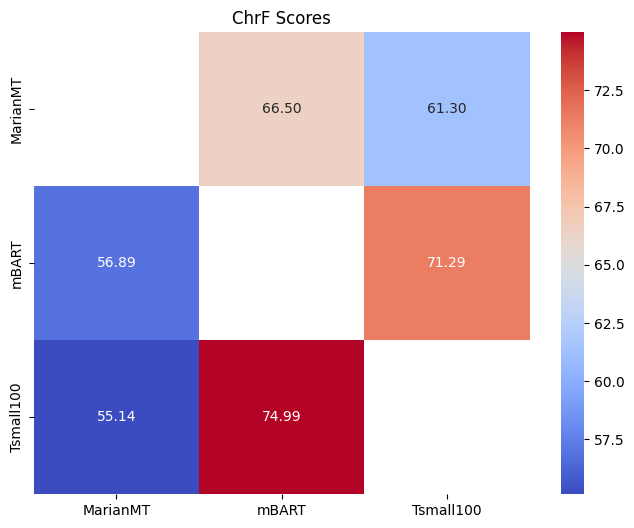

In [16]:
# Plot the results for each metric
for metric in metrics:
    plot_heatmap(metric_dfs[metric], f'{metric} Scores')